In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path

In [3]:
from fieldplot import GetFlow3D

In [1]:
import scattnlay
from scattnlay import fieldnlay
from scattnlay import scattnlay

In [32]:
WL=450 #nm 				# wave length
core_r = 90.0			# partical radius

x = np.ones((1), dtype = np.float64)
x[0] = core_r/WL*2.0*np.pi

npts = 151					# plot will be npts x npts
factor=1.5					# area of plot

epsilon = 15.813 		# dielectric permitivity
index = np.sqrt(epsilon)	# refractive index
nm = 1.0						# refractive index of host media

m = np.ones((1), dtype = np.complex128)
m[0] = index/nm

In [33]:
scan = np.linspace(-factor*x[-1], factor*x[-1], npts)
zero = np.zeros(npts*npts, dtype = np.float64)

coordX, coordZ = np.meshgrid(scan, scan)
coordX.resize(npts * npts)
coordZ.resize(npts * npts)
coordY = zero

coordPlot1 = coordX
coordPlot2 = coordZ

coord = np.vstack((coordX, coordY, coordZ)).transpose()
terms, E, H = fieldnlay(np.array([x]), np.array([m]), coord, pl=-1)
Ec = E[0, :, :]
Hc = H[0, :, :]
P = np.array(map(lambda n: np.linalg.norm(np.cross(Ec[n], Hc[n])).real, range(0, len(E[0]))))

CPU times: user 1.61 s, sys: 164 ms, total: 1.78 s
Wall time: 1.54 s


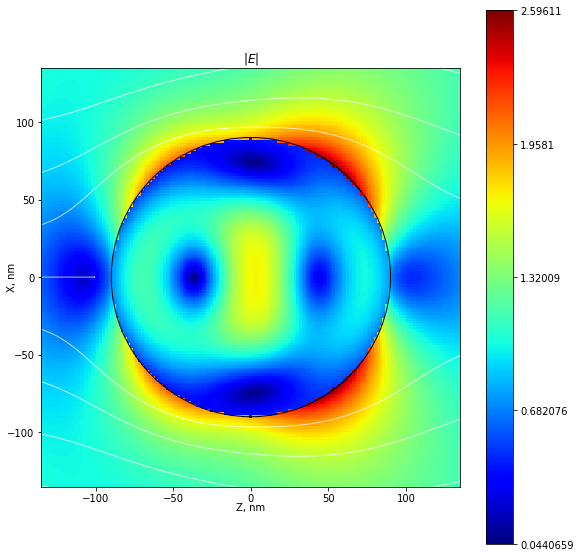

In [35]:
%%time

# def fieldplot(...)
field_to_plot='Eabs'
WL_units='nm'
outline_width = 1
flow_total = 9				# number of powerflow steamlines 

fig, ax = plt.subplots(1,1, figsize=(8,8))#, sharey=True, sharex=True)
fig.tight_layout()

Er = np.absolute(Ec)
Hr = np.absolute(Hc)

Eabs = np.sqrt(Er[:, 0]**2 + Er[:, 1]**2 + Er[:, 2]**2)
label = r'$|E|$'
Eabs_data = np.resize(Eabs, (npts, npts)).T

# Rescale to better show the axes
scale_x = np.linspace(
    min(coordX) * WL / 2.0 / np.pi, max(coordX) * WL / 2.0 / np.pi, npts)
scale_z = np.linspace(
    min(coordZ) * WL / 2.0 / np.pi, max(coordZ) * WL / 2.0 / np.pi, npts)

# Define scale ticks
min_tick = np.amin(Eabs_data[~np.isnan(Eabs_data)])
#min_tick = 0.1
max_tick = np.amax(Eabs_data[~np.isnan(Eabs_data)])
#max_tick = 60
scale_ticks = np.linspace(min_tick, max_tick, 5)
#scale_ticks = np.power(10.0, np.linspace(np.log10(min_tick), np.log10(max_tick), 6))
#scale_ticks = [0.1,0.3,1,3,10, max_tick]
# Interpolation can be 'nearest', 'bilinear' or 'bicubic'
ax.set_title(label)
# build a rectangle in axes coords
ax.annotate(' ', xy=(0.0, 1.1), xycoords='axes fraction',  # fontsize=10,
            horizontalalignment='left', verticalalignment='top')

cax = ax.imshow(Eabs_data, interpolation='nearest', cmap=cm.jet,
                origin='lower', vmin=min_tick, vmax=max_tick, extent=(min(scale_x), max(scale_x), min(scale_z), max(scale_z))
                # ,norm = LogNorm()
                )
ax.axis("image")

# Add colorbar
cbar = fig.colorbar(cax, ticks=[a for a in scale_ticks], ax=ax)
# vertically oriented colorbar
if 'angle' in field_to_plot:
    cbar.ax.set_yticklabels(['%3.0f' % (a) for a in scale_ticks])
else:
    cbar.ax.set_yticklabels(['%g' % (a) for a in scale_ticks])
# pos = list(cbar.ax.get_position().bounds)
#fig.text(pos[0] - 0.02, 0.925, '|E|/|E$_0$|', fontsize = 14)
lp2 = -10.0
lp1 = -1.0

#if crossplane == 'XZ':
ax.set_xlabel('Z, ' + WL_units, labelpad=lp1)
ax.set_ylabel('X, ' + WL_units, labelpad=lp2)

for xx in x:
    r = xx * WL / 2.0 / np.pi
    s1 = patches.Arc((0, 0), 2.0 * r, 2.0 * r,  angle=0.0, zorder=1.8,
                     theta1=0.0, theta2=360.0, linewidth=outline_width, color='black')
    ax.add_patch(s1)
#
# (not crossplane == 'XY') and 
if flow_total > 0:
    scanSP = np.linspace(-factor * x[-1], factor * x[-1], npts)
    min_SP = -factor * x[-1]
    step_SP = 2.0 * factor * x[-1] / (flow_total - 1)
    x0, y0, z0 = 0, 0, 0
    max_length = factor * x[-1] * 10
    # max_length=factor*x[-1]*5
    max_angle = np.pi / 160
    rg = range(0, flow_total)
    for flow in rg:
        f = min_SP + flow*step_SP
        x0 = f
        z0 = min_SP
        
        flow_xSP, flow_ySP, flow_zSP = GetFlow3D(x0, y0, z0, max_length, max_angle, x, m, -1)
        
        flow_z_plot = flow_zSP * WL / 2.0 / np.pi
        flow_f_plot = flow_xSP * WL / 2.0 / np.pi

        verts = np.vstack(
            (flow_z_plot, flow_f_plot)).transpose().tolist()
        codes = [Path.LINETO] * len(verts)
        codes[0] = Path.MOVETO
        path = Path(verts, codes)
        patch = patches.PathPatch(
            path, facecolor='none', lw=outline_width, edgecolor='white', zorder=1.9, alpha=0.7)
        ax.add_patch(patch)
        
fig.subplots_adjust(hspace=0.3, wspace=-0.1)